# Setting up

In [ ]:
import warnings
warnings.filterwarnings('ignore')

!wget https://www.dropbox.com/scl/fi/df9wwhemwn9gt0qtnq9ro/garden_dataset.zip?rlkey=2cjceu0zeesxdy9zwiga73nog&dl=0

In [1]:
!unzip garden_dataset.zip

Archive:  garden_dataset.zip
replace __MACOSX/._garden_dataset? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


## Dataset Pre-processing

In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2

In [4]:

import os
import shutil

if os.path.exists("./train"):
    shutil.rmtree("./train")
os.makedirs("./train")

if os.path.exists("./test"):
    shutil.rmtree("./test")
os.makedirs("./test")


cassava = len(os.listdir('./garden_dataset/cassava'))
maize = len(os.listdir('./garden_dataset/maize'))
sugarcane = len(os.listdir('./garden_dataset/sugarcane'))
grass = len(os.listdir('./garden_dataset/grass'))

print(f"{cassava} Cassava Images")
print(f"{maize} Maize Images")
print(f"{sugarcane} Sugar Cane Images")
print(f"{grass} Grass Images")

327 Cassava Images
305 Maize Images
115 Sugar Cane Images
287 Grass Images


In [5]:
def populate_for_class():
  data_test = []
  data_train = []
  classes = [
      {
          "dir": 'garden_dataset/cassava',
          "label": 0
      },
      {
          "dir": 'garden_dataset/grass',
          "label": 1
      },
      {
          "dir": 'garden_dataset/maize',
          "label": 2
      },
      {
          "dir": 'garden_dataset/sugarcane',
          "label": 3
      }
  ]
  for dataset_class in classes:
    label = dataset_class['label']
    src = dataset_class['dir']
    images = os.listdir(src)
    split = int(len(images) * 0.8)
    for i, img in enumerate(images):
      if i < split:
        shutil.copy(os.path.join(src, img), os.path.join(f"train/", img))
        data_train.append([os.path.join(f"train/", img), label])
      else:
        shutil.copy(os.path.join(src, img), os.path.join(f"test/", img))
        data_test.append([os.path.join(f"test/", img), label])

  return data_train, data_test

In [6]:
data_train, data_test = populate_for_class()

# Save train labels to csv file.
data_train = pd.DataFrame(data_train, columns=['image_path', 'label'])
data_train.to_csv('labels_train.csv')
data_train.head()

,image_path,label
0,train/image_c_19.jpg,0
1,train/image_c_25.jpg,0
2,train/image_c_31.jpg,0
3,train/image_c_103.jpg,0
4,train/image_c_117.jpg,0


In [7]:
# Save train labels to csv file.
data_test = pd.DataFrame(data_test, columns=['image_path', 'label'])
data_test.to_csv('labels_test.csv')
data_test.head()

,image_path,label
0,test/image_c_255.jpg,0
1,test/image_c_269.jpg,0
2,test/image_c_282.jpg,0
3,test/image_c_296.jpg,0
4,test/image_c_2.jpg,0


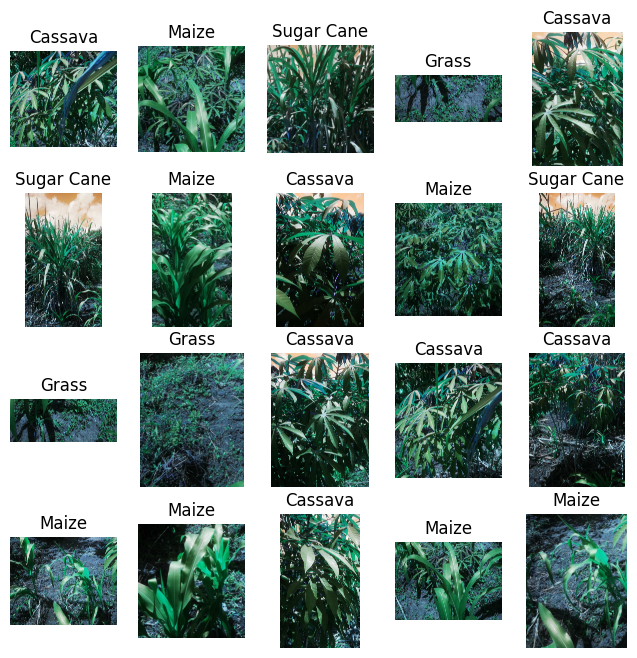

In [9]:
labels_map = {
    0: "Cassava",
    1: "Grass",
    2: "Maize",
    3: "Sugar Cane"
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 4
for i in range(1, 21):
    sample_idx = random.randint(0, len(data_train['image_path']))
    img = cv2.imread(data_train.iloc[sample_idx].image_path)
    label = data_train.iloc[sample_idx].label
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

# Naive Beyes Model: Edge Detection Feature

In [8]:
from sklearn.utils import shuffle
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

In [9]:
import cv2
import matplotlib.pyplot as plt

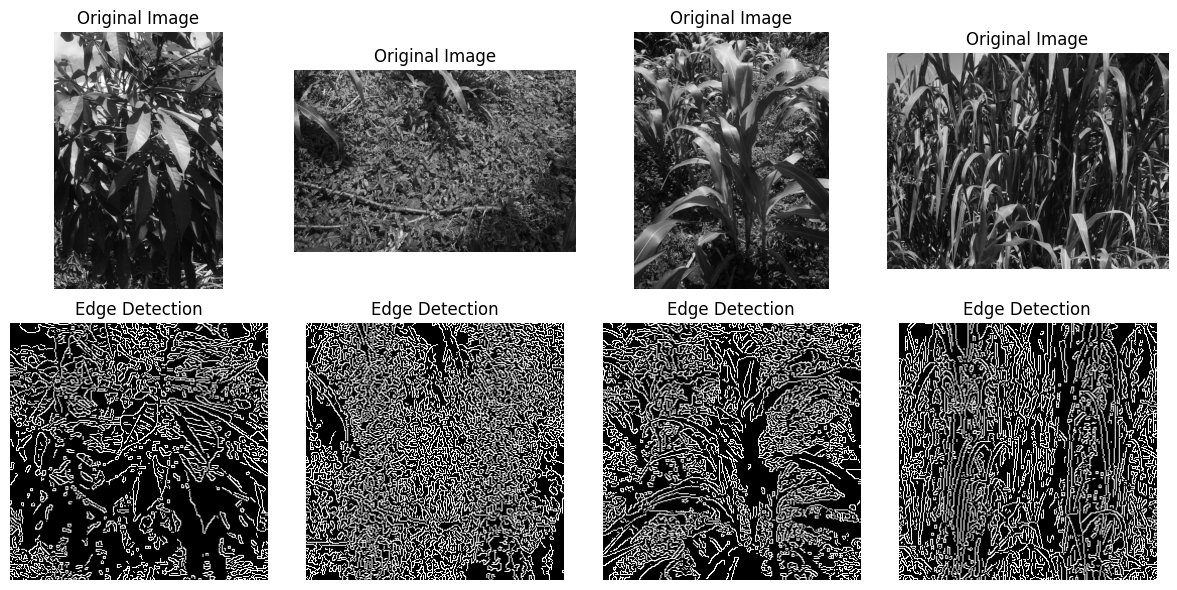

In [10]:
import cv2
import matplotlib.pyplot as plt

def auto_canny_edge_detection(image, sigma=0.33):
    # Apply Gaussian filter to the image
    blurred = cv2.GaussianBlur(image, (3, 3), 0)

    # Compute median of the blurred image
    md = np.median(blurred)

    # Calculate lower and upper thresholds using the sigma value
    lower_value = int(max(0, (1.0 - sigma) * md))
    upper_value = int(min(255, (1.0 + sigma) * md))

    # Apply Canny edge detection
    edges = cv2.Canny(blurred, lower_value, upper_value)

    # Perform maximum suppression
    suppressed_edges = non_max_suppression(edges)

    return suppressed_edges

def non_max_suppression(edges):
    # Perform non-maximum suppression on the edges
    edges_copy = edges.copy()
    contours, _ = cv2.findContours(edges_copy, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        edges_copy[y:y+h, x:x+w] = cv2.dilate(edges_copy[y:y+h, x:x+w], None)
        edges_copy[edges_copy != edges] = 0

    return edges_copy


# Read and preprocess images
image_paths = ['./garden_dataset/cassava/image_c_10.jpg', './garden_dataset/grass/image_g_11.jpg', './garden_dataset/maize/image_m_104.jpg', './garden_dataset/sugarcane/image_s_1.jpg']
images = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in image_paths]
processed_images = [cv2.resize(image, (256, 256)) for image in images]

# Apply auto_canny_edge_detection to images
edges = [auto_canny_edge_detection(image) for image in processed_images]

# Display original images and edge detection results
num_images = len(image_paths)
fig, axs = plt.subplots(2, num_images, figsize=(12, 6))
for i in range(num_images):
    axs[0, i].imshow(images[i], cmap='gray')
    axs[0, i].set_title('Original Image')
    axs[0, i].axis('off')

    axs[1, i].imshow(edges[i], cmap='gray')
    axs[1, i].set_title('Edge Detection')
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()


In [11]:
labels = data_train['label']
image_paths = data_train['image_path']

def auto_canny_edge_detection(image, sigma=0.33):
    # Apply Gaussian filter to the image
    blurred = cv2.GaussianBlur(image, (3, 3), 0)

    # Compute median of the blurred image
    md = np.median(blurred)

    # Calculate lower and upper thresholds using the sigma value
    lower_value = int(max(0, (1.0 - sigma) * md))
    upper_value = int(min(255, (1.0 + sigma) * md))

    # Apply Canny edge detection
    edges = cv2.Canny(blurred, lower_value, upper_value)

    # Perform maximum suppression
    suppressed_edges = non_max_suppression(edges)

    return edges

def non_max_suppression(edges):
    # Perform non-maximum suppression on the edges
    edges_copy = edges.copy()
    contours, _ = cv2.findContours(edges_copy, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        edges_copy[y:y+h, x:x+w] = cv2.dilate(edges_copy[y:y+h, x:x+w], None)
        edges_copy[edges_copy != edges] = 0

    return edges_copy

feature_vectors = []
extracted_labels = []


# Extract Image features
for path, label in zip(image_paths, labels):
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (500, 500))

    # Extract edges using auto_canny_edge_detection function
    edges = auto_canny_edge_detection(image)
    edge_features = edges.flatten()

    if len(edge_features) > 0:
        feature_vectors.append(edge_features)
        extracted_labels.append(label)

feature_vectors = np.array(feature_vectors)
extracted_labels = np.array(extracted_labels)

# Train model
naive_bayes = GaussianNB()
naive_bayes.fit(feature_vectors, extracted_labels)

GaussianNB()

In [12]:
from sklearn.utils import shuffle

data_test = shuffle(data_test)
labels_test1 = data_test['label']
image_paths_test1 = data_test['image_path']

output_labels1 = []

correct = 0
for path, label in zip(image_paths_test1, labels_test1):
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (500, 500))

    # Extract edges using auto_canny_edge_detection function
    edges = auto_canny_edge_detection(image)
    edge_features = edges.flatten()

    if len(edge_features) > 0:
        # Predict label using the trained Naïve Bayes classifier
        image_label = naive_bayes.predict([edge_features])
        output_labels1.append(image_label)
        if image_label == label:
            correct += 1


In [14]:
# Evaluate model
accuracy = accuracy_score(np.array(labels_test1), np.array(output_labels1))
print("Accuracy:", accuracy)

Accuracy: 0.6153846153846154


In [15]:
print(classification_report(np.array(labels_test1), np.array(output_labels1)))

              precision    recall  f1-score   support

           0       0.57      0.59      0.58        66
           1       0.61      1.00      0.76        58
           2       0.67      0.46      0.54        61
           3       1.00      0.13      0.23        23

    accuracy                           0.62       208
   macro avg       0.71      0.55      0.53       208
weighted avg       0.66      0.62      0.58       208



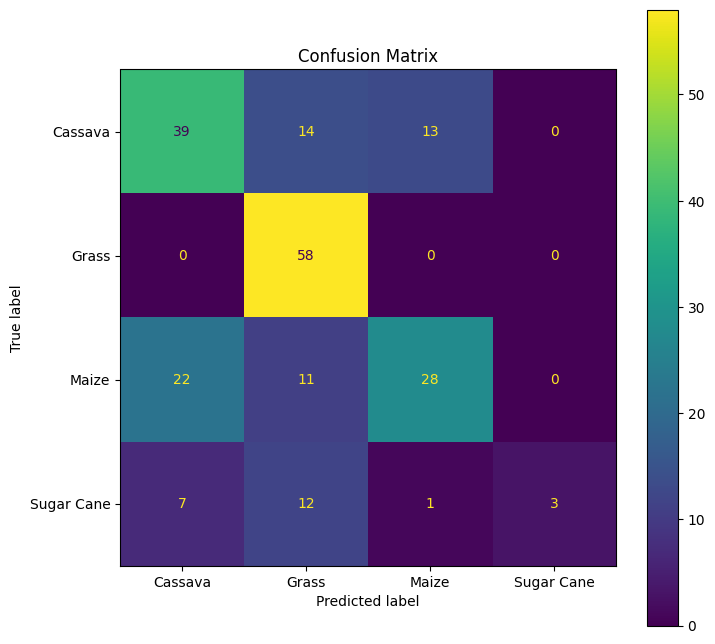

In [17]:
matrix = confusion_matrix(np.array(labels_test1), np.array(output_labels1))
cm_display = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels=['Cassava', 'Grass', 'Maize', 'Sugar Cane'])

plt.figure(figsize=(8,8))
plt.title(f"Confusion Matrix")
cm_display.plot(ax=plt.subplot())
plt.show()

# Train NB Model: Color histogram features

<Figure size 800x800 with 0 Axes>

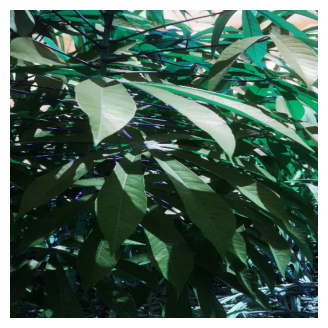

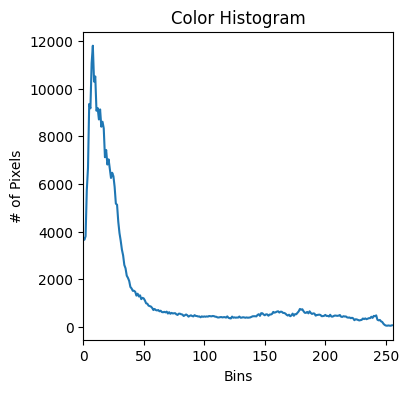

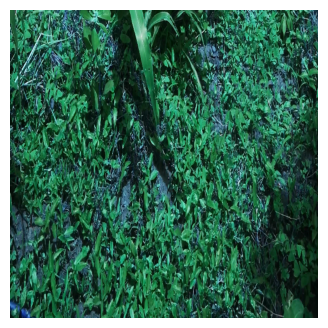

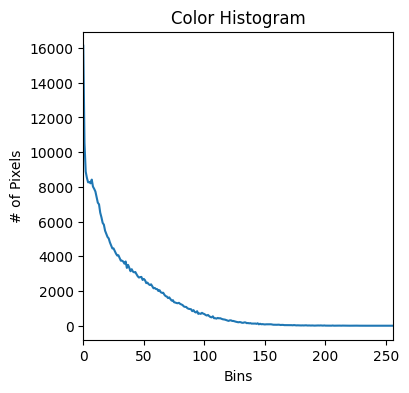

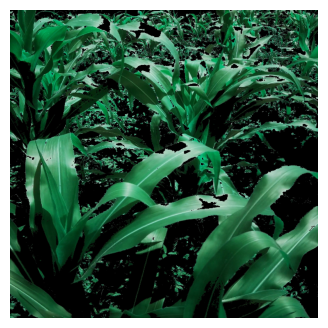

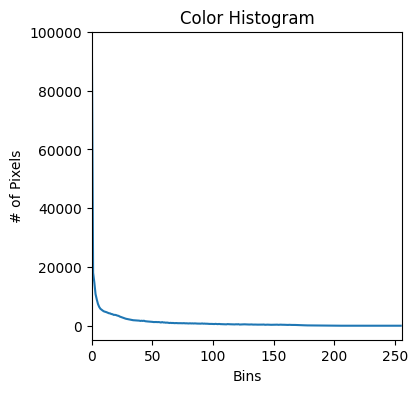

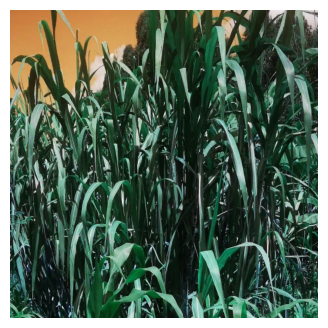

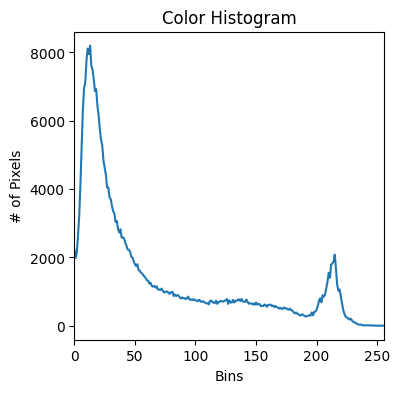

In [60]:


sample_images = ['cassava/image_c_20.jpg', 'grass/image_g_33.jpg', 'maize/image_m_90.jpg', 'sugarcane/image_s_7.jpg']
count = 1
cols, rows = 4, 4
figure = plt.figure(figsize=(8, 8))
for path in sample_images:
    img = cv2.imread('garden_dataset/' + path)
    img = cv2.resize(img, (600, 600))
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])

    plt.figure(figsize=(4, 4))
    plt.axis("off")
    plt.imshow(img)
    # plot the histogram
    plt.figure(figsize=(4, 4))
    plt.title("Color Histogram")
    plt.xlabel("Bins")
    plt.ylabel("# of Pixels")
    plt.plot(hist)
    plt.xlim([0, 256])

In [25]:
labels = data_train['label']
image_paths = data_train['image_path']

feature_vectors = []
# Extract Image features
for path in image_paths:
    image = cv2.imread(path)
    image = cv2.resize(image, (500, 500))
    image = cv2.calcHist([image], [0], None, [256], [0, 256])

    feature_vectors.append(image.flatten())

feature_vectors = np.array(feature_vectors)
labels = np.array(labels)

# Train model
naive_bayes = GaussianNB()
naive_bayes.fit(feature_vectors, labels)

GaussianNB()

In [26]:
labels_test = data_test['label']
image_paths_test = data_test['image_path']

feature_vectors = []
for path, label in zip(image_paths_test, labels_test):
    image = cv2.imread(path)
    image = cv2.resize(image, (500, 500))
    image = cv2.calcHist([image], [0], None, [256], [0, 256])
    feature_vectors.append(image.flatten())

output_labels = naive_bayes.predict(np.array(feature_vectors))

# Evaluate model

In [27]:

accuracy = accuracy_score(np.array(labels_test), np.array(output_labels))
print("Accuracy:", accuracy)

Accuracy: 0.7487179487179487


In [28]:
print(classification_report(np.array(labels_test), np.array(output_labels)))

              precision    recall  f1-score   support

           0       0.82      0.62      0.70        60
           1       0.80      0.83      0.81        58
           2       0.62      0.80      0.70        56
           3       0.89      0.76      0.82        21

    accuracy                           0.75       195
   macro avg       0.78      0.75      0.76       195
weighted avg       0.77      0.75      0.75       195



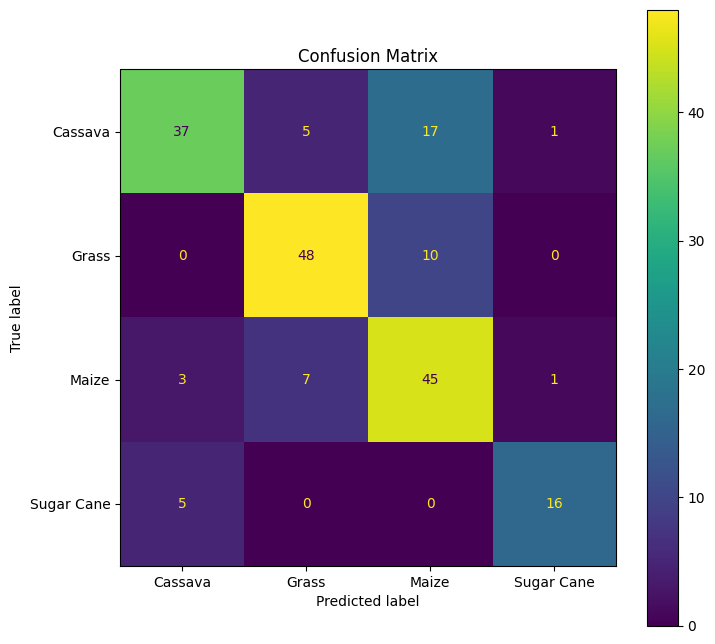

In [29]:
matrix = confusion_matrix(np.array(labels_test), np.array(output_labels))
cm_display = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels=['Cassava', 'Grass', 'Maize', 'Sugar Cane'])

plt.figure(figsize=(8,8))
plt.title(f"Confusion Matrix")
cm_display.plot(ax=plt.subplot())
plt.show()

# Train NB Model: Color histogram AND Edge Detection Combined Features

In [18]:
import cv2
import numpy as np
from sklearn.naive_bayes import GaussianNB

labels = data_train['label']
image_paths = data_train['image_path']

# Function for auto Canny edge detection
def auto_canny_edge_detection(image, sigma=0.33):
    md = np.median(image)
    lower_value = int(max(0, (1.0 - sigma) * md))
    upper_value = int(min(255, (1.0 + sigma) * md))
    return cv2.Canny(image, lower_value, upper_value)

# Initialize empty lists to store the feature vectors and labels
feature_vectors = []
extracted_labels = []

# Extract Image features (Edges + Histogram)
for path, label in zip(image_paths, labels):
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (600, 600))

    # Extract edges using auto_canny_edge_detection
    edges = auto_canny_edge_detection(image)
    edge_features = edges.flatten()

    # Extract histogram features
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist_features = hist.flatten()

    # Combine edge and histogram features into a single feature vector
    combined_features = np.concatenate((edge_features, hist_features), axis=0)

    feature_vectors.append(combined_features)
    extracted_labels.append(label)

feature_vectors = np.array(feature_vectors)
extracted_labels = np.array(extracted_labels)

# Train model
naive_bayes = GaussianNB()
naive_bayes.fit(feature_vectors, labels)

GaussianNB()

In [19]:
from sklearn.utils import shuffle

data_test = shuffle(data_test)
labels_test = data_test['label']
image_paths_test = data_test['image_path']

output_labels = []

correct = 0
for path, label in zip(image_paths_test, labels_test):
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (600, 600))

    # Extract edges using auto_canny_edge_detection function
    edges = auto_canny_edge_detection(image)
    edge_features = edges.flatten()

    # Extract histogram features
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist_features = hist.flatten()

    # Combine edge and histogram features into a single feature vector
    combined_features = np.concatenate((edge_features, hist_features), axis=0)

    if len(combined_features) > 0:
        # Predict label using the trained Naïve Bayes classifier
        image_label = naive_bayes.predict([combined_features])
        output_labels.append(image_label)
        if image_label == label:
            correct += 1


# Elavuate Model 

In [20]:
# Evaluate model
accuracy = accuracy_score(np.array(labels_test), np.array(output_labels))
print("Accuracy:", accuracy)

Accuracy: 0.6442307692307693


In [21]:
print(classification_report(np.array(labels_test), np.array(output_labels)))

              precision    recall  f1-score   support

           0       0.50      0.65      0.57        66
           1       0.98      0.79      0.88        58
           2       0.54      0.51      0.53        61
           3       0.78      0.61      0.68        23

    accuracy                           0.64       208
   macro avg       0.70      0.64      0.66       208
weighted avg       0.68      0.64      0.65       208



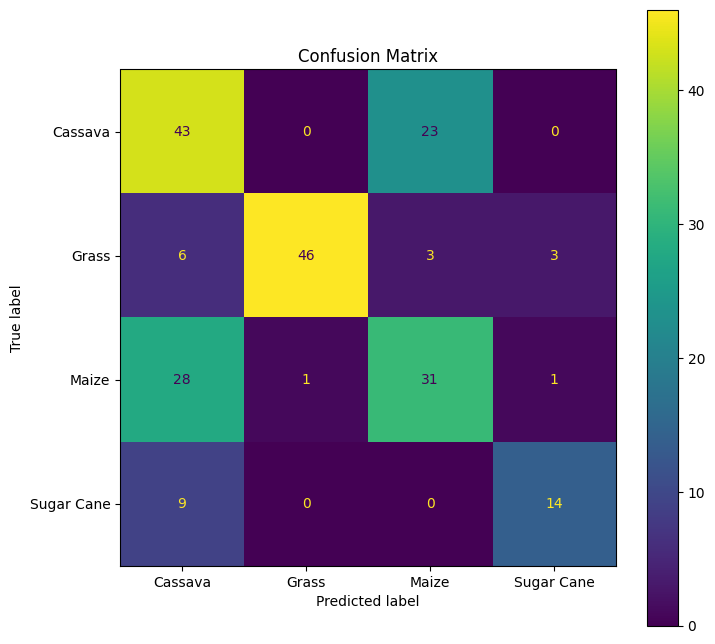

In [22]:
matrix = confusion_matrix(np.array(labels_test), np.array(output_labels))
cm_display = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels=['Cassava', 'Grass', 'Maize', 'Sugar Cane'])

plt.figure(figsize=(8,8))
plt.title(f"Confusion Matrix")
cm_display.plot(ax=plt.subplot())
plt.show()